# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations[abs(correlations) > 0.4])

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
frl_percent                            -0.722225
sped_percent                           -0.448170
asian_num                               0.475445
asian_per                               0.570730
white_num                               0.449559
white_per                               0.620718
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
Name: sat_score, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")


In [11]:
#imports matplotlib to run in jupyter
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
#select columns that contain correlations of SAT score and survey data
survey_corr = correlations[survey_fields]
print(survey_corr[survey_corr > 0.3])

N_s           0.423463
N_p           0.421530
saf_t_11      0.313810
saf_s_11      0.337639
aca_s_11      0.339435
saf_tot_11    0.318753
Name: sat_score, dtype: float64


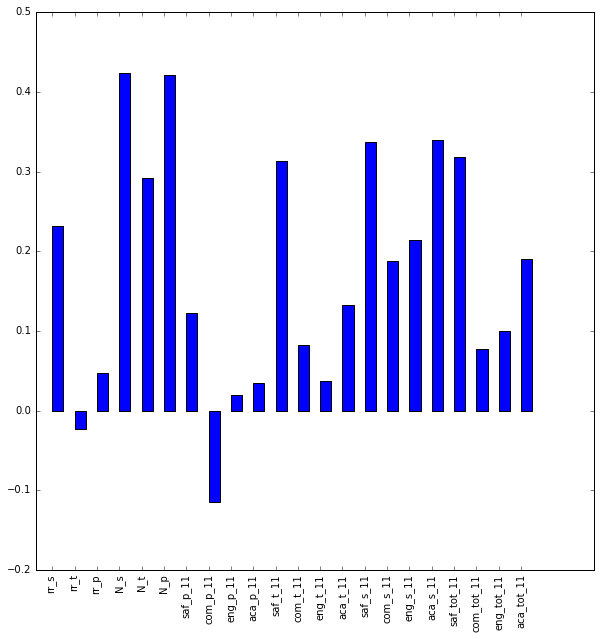

In [13]:
from numpy import arange
bar_positions = arange(22) + 0.75
tick_positions = arange(22) + 0.75
bar_heights = survey_corr.values

fig, ax = plt.subplots(figsize=(10,10))
ax.bar(bar_positions, bar_heights, 0.5)
ax.set_xticks(tick_positions)
ax.set_xticklabels(survey_fields, rotation=90)
plt.show()

the most significant correlations (absolute value > 0.3) were the number of student and parent respondents (N_s and N_p), the academic expectations percieved by students (aca_s), and the safety and respect percieved by teachers, students, and total (saf_t, saf_s, saf_tot).  To visualize safety scores by district, I want to group the data by district number ('school_dist' column) and map by average latitude and longitude for each district, using a seaborn color palette to visualize the scores.

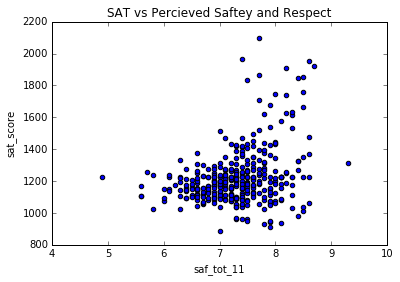

In [14]:
#create a scatter plot of safety scores vs SAT scores
combined.plot(x='saf_tot_11', y='sat_score', kind='scatter', title='SAT vs Percieved Saftey and Respect')

In [15]:
#create a pivot table with the average values I am interested in
safety_pvt = combined.pivot_table(values=['sat_score', 'saf_tot_11', 'lat', 'lon'], index='school_dist', aggfunc=[numpy.mean])
print(safety_pvt.head())

                  mean                                   
                   lat        lon saf_tot_11    sat_score
school_dist                                              
01           40.719022 -73.982377   7.433333  1354.500000
02           40.739699 -73.991386   7.520833  1295.638184
03           40.781574 -73.977370   7.233333  1293.443035
04           40.793449 -73.943215   7.714286  1224.142857
05           40.817077 -73.949251   7.085714  1285.062687


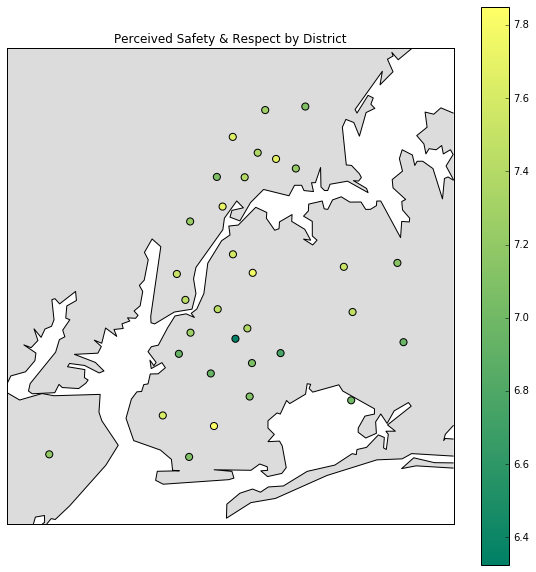

In [57]:
#import basemap for creating geographic plots
from mpl_toolkits.basemap import Basemap

#create a mercadian projection of the basemap
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Perceived Safety & Respect by District')
m = Basemap(projection='merc', llcrnrlat=40.54, urcrnrlat=40.92, llcrnrlon=-74.17, urcrnrlon=-73.7, resolution='h')
m.drawcoastlines()
m.fillcontinents(color=(220/255,220/255,220/255), zorder=0)

#convert latitudes and longitudes to list
latitudes = safety_pvt['mean']['lat'].tolist()
longitudes = safety_pvt['mean']['lon'].tolist()

#define as x and y in basemap
x, y = m(longitudes, latitudes)

#create scatter plot
m.scatter(x, y, s=50, c=safety_pvt['mean']['saf_tot_11'], cmap='summer')
plt.colorbar()
plt.show()

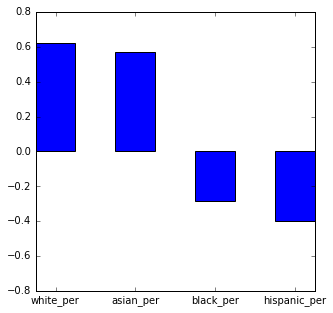

In [72]:
#looking at racial correlations with sat score
groups = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
racial_corr = correlations[groups]
#racial_corr.plot(kind='bar', x)

bar_positions = arange(4) + 3
tick_positions = arange(4) + 3.25
bar_heights = racial_corr.values

fig, ax = plt.subplots(figsize=(5,5))
ax.bar(bar_positions, bar_heights, .5)
ax.set_xticks(tick_positions)
ax.set_ylim(-0.8, 0.8)
ax.set_xticklabels(groups, rotation=0)
plt.show()

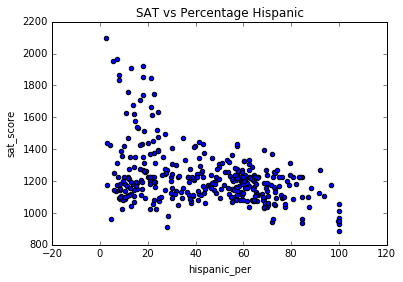

In [73]:
#scatter plot of hispanic_per vs sat_score
combined.plot(x='hispanic_per', y='sat_score', kind='scatter', title='SAT vs Percentage Hispanic')

In [81]:
hispanic_bool = combined[combined['hispanic_per'] < 10]
sat_bool = hispanic_bool[hispanic_bool['sat_score'] > 1800]
print(sat_bool['SCHOOL NAME'])

#all of these schools are specialized/technical schools

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [82]:
hispanic_bool = combined[combined['hispanic_per'] > 95]
print(hispanic_bool['SCHOOL NAME'])
#all of them have dual language
#or international components, geared toward spanish

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


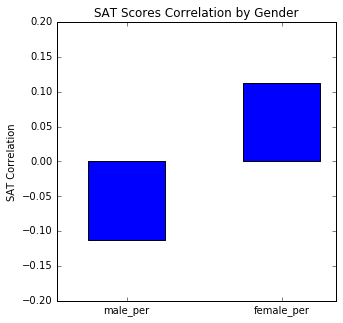

In [86]:
#looking at gendr correlations with sat score
groups = ['male_per', 'female_per']
gender_corr = correlations[groups]

bar_positions = arange(2) + 3
tick_positions = arange(2) + 3.25
bar_heights = gender_corr.values

fig, ax = plt.subplots(figsize=(5,5))
ax.bar(bar_positions, bar_heights, .5)
ax.set_xticks(tick_positions)
ax.set_ylim(-0.2, 0.2)
ax.set_ylabel('SAT Correlation')
ax.set_title('SAT Scores Correlation by Gender')
ax.set_xticklabels(groups, rotation=0)
plt.show()
#surprisingly a positive correlation between female percentage and SAT scores - not
#extremely strong but there

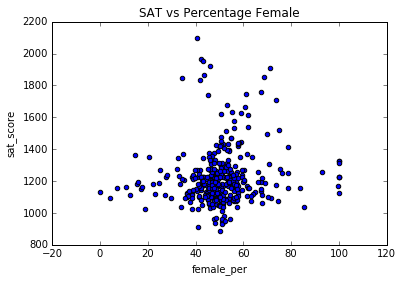

In [87]:
#scatter plot of gender vs sat_score
combined.plot(x='female_per', y='sat_score', kind='scatter', title='SAT vs Percentage Female')
#the highest scores seem to come from schools with a distribution of females between ~30% and ~70%

In [88]:
#schools with female percentage > 60% and SAT score > 1700
female_bool = combined[combined['female_per'] > 60]
sat_bool = female_bool[female_bool['sat_score'] > 1700]
print(sat_bool['SCHOOL NAME'])

#according to this article some of these schools have begun admitting
#students based on grades and classroom behavior in middle school,
#which girls score better on: 
#https://nypost.com/2019/02/18/parents-say-citys-new-admissions-plans-will-hurt-boys-more-than-girls/

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


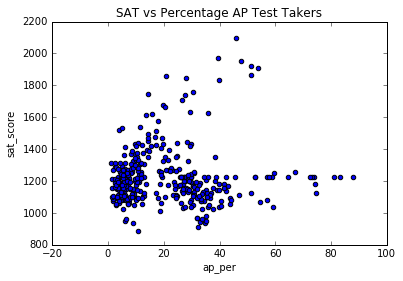

In [90]:
#create ap percentage column
combined['ap_per'] = (combined['AP Test Takers '] / combined['total_enrollment'])*100

#scatter plot of percentage of ap test takers vs sat_score
combined.plot(x='ap_per', y='sat_score', kind='scatter', title='SAT vs Percentage AP Test Takers')
